I chose to work on "Amazon Fine Food Reviews" dataset, which provides reviews of fine foods from Amazon. It has around 560,000 reviews, and its fields are: Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Time, Summary andText.
Actually, many problems can be tackeld by this dataset, also many prediction models can be build using it. But I chose to work on sentiment analysis for the review (Text), so I worked mainly on Score and Text columns.
The data is imbalanced, I assumed that reviews that have score equals to 4 or 5 are Positive. While reviews that have score equals to 3 or 2 or 1 are Negative.
I assumed that I have a binary classification task. After data prepration I trained different classifiers:
First, I built NBSVM baseline model.
Second, I built LSTM model.
Third, I built LSTM-CNN model
I evaluated my models by calculateing Accuracy, F1 Score, Presision and Recall.
I believe that there is a margine for improving the models, but deep learning models need time for tuning the different hyperparameters.

In [28]:
#Load Libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import re, string, os, sys
import argparse
from string import digits
from logging import info, basicConfig, INFO
from gensim.models import KeyedVectors
from nltk.tokenize import wordpunct_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from gensim.models import KeyedVectors
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Conv1D,Flatten,Concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
#Load Data
df = pd.read_csv('Reviews.csv', usecols=['Score', 'Text'])
#df = pd.read_csv('Reviews.csv')
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [3]:
df.count()

Score    568454
Text     568454
dtype: int64

In [4]:
df.dropna(inplace=True)
df.count()

Score    568454
Text     568454
dtype: int64

In [5]:
def clean(df):
            english_punctuations = string.punctuation
            df['Text'] = df['Text'].map(lambda x: str(x).lower())
            #Drop \n and  \t
            df["Text"] = df["Text"].str.replace("\n"," ") 
            df["Text"] = df["Text"].str.replace("\r"," ") 
            df["Text"] = df["Text"].str.replace("\t"," ") 
            df["Text"] = df["Text"].str.replace("\b"," ") 
            #remove punctuations
            df['Text'] = df['Text'].map(lambda x: re.sub("["+english_punctuations+"]",'',str(x)))
            # remove_repeating_char(text):
            df['Text'] = df['Text'].map(lambda x: re.sub(r'(.)\1+', r'\1', str(x))) 
            #remove any review that start with user
            df['Text'] = df['Text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
            # remove IP addresses or user IDs
            df['Text'] = df['Text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
            df['Text'] = df['Text'].map(lambda x: re.sub(r'[^\x00-\x7f]','',str(x)))
            #remove http links in the text
            df['Text'] = df['Text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)",'',str(x)))
            df['Text'] = df['Text'].map(lambda x: re.sub("["+digits+"]",'',str(x)))
            return df

In [6]:
df=clean(df)

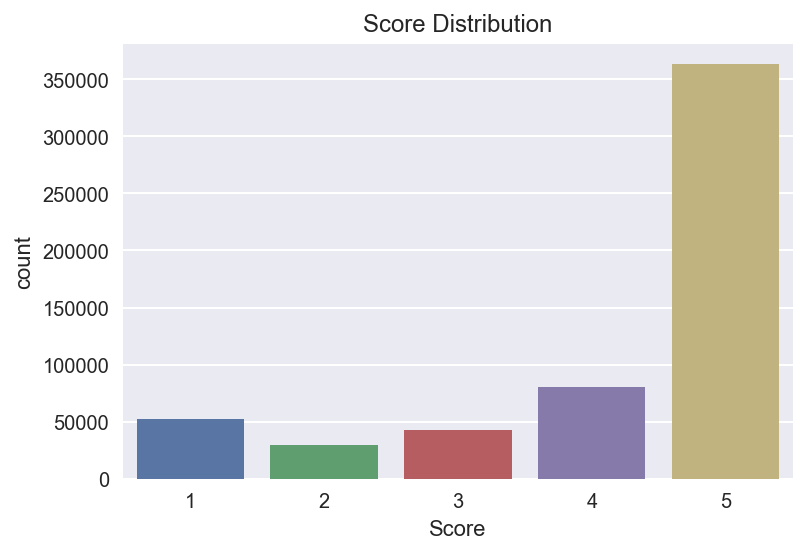

In [7]:
ax  =  plt.axes()
sns.countplot(df.Score,ax=ax)
ax.set_title('Score Distribution')
plt.show()

In [8]:
#Delete rows with empty values
df.dropna(inplace=True)

#Convert the problem into binary classification: POSITIVE: Score>3, NEGATIVE: Score<=3
df['sentiment'] = np.where(df['Score'] > 3, 1, 0)
pos=df[df.sentiment == 1]
neg=df[df.sentiment == 0]
print(len(pos))
print(len(neg))

443777
124677


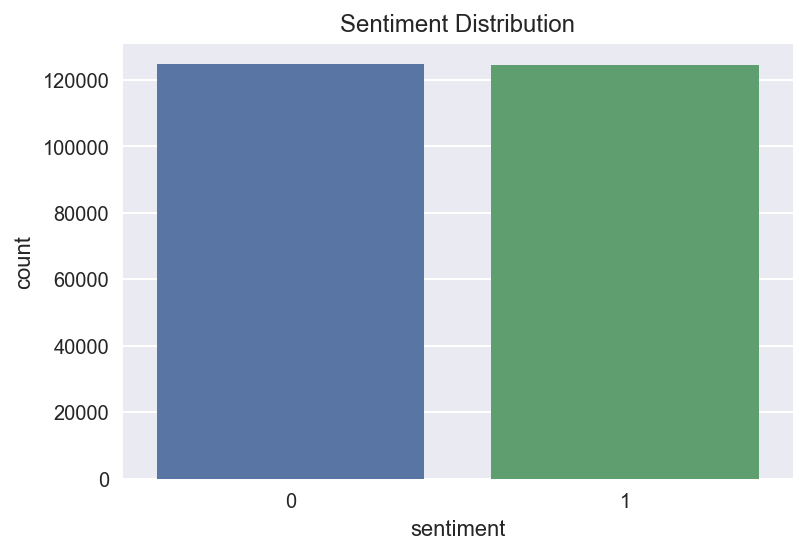

In [9]:
#Balance classes
pos = shuffle(pos)
pos1=pos[0:124650]
df=pd.concat([pos1, neg])
df = shuffle(df)
ax  =  plt.axes()
sns.countplot(df.sentiment,ax=ax)
ax.set_title('Sentiment Distribution')
plt.show()

In [10]:
df.count()

Score        249327
Text         249327
sentiment    249327
dtype: int64

In [11]:
df.sentiment.value_counts()

0    124677
1    124650
Name: sentiment, dtype: int64

In [12]:
train, test = train_test_split(df, test_size=0.15)

In [13]:
train.count()

Score        211927
Text         211927
sentiment    211927
dtype: int64

In [13]:
test.count()

Score        37400
Text         37400
sentiment    37400
dtype: int64

In [14]:
label_cols=['sentiment']

In [20]:
#Machine Learning : Baseline Model
#Using Naive Bayes and Logistic Regression models (NVSVM Baseline model)
import re
import string
re_tok = re.compile(r'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenize, strip_accents='unicode' )
trn_term_doc = vec.fit_transform(train['Text'])
test_term_doc = vec.transform(test['Text'])
trn_term_doc, test_term_doc
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)
x = trn_term_doc
test_x = test_term_doc
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
submission = 88

fit sentiment


In [21]:
#Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import confusion_matrix 

y_pred=preds.round()
y_true=test["sentiment"]

print('\n Testing accuracy is {}'.format(accuracy_score(y_true, y_pred)))
print ('\n F1',f1_score(y_true,y_pred, average='weighted'))
print ('\n Recall:', recall_score(y_true, y_pred,average='weighted'))
print ('\n Precision:', precision_score(y_true, y_pred, average='weighted'))
print ('\n clasification report:\n', classification_report(y_true, y_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_true, y_pred))


 Testing accuracy is 0.8706417112299465

 F1 0.8706364949834503

 Recall: 0.8706417112299465

 Precision: 0.8706752840383434

 clasification report:
              precision    recall  f1-score   support

          0       0.87      0.88      0.87     18756
          1       0.87      0.87      0.87     18644

avg / total       0.87      0.87      0.87     37400


 confussion matrix:
 [[16431  2325]
 [ 2513 16131]]


## Deep Learning

In [18]:
#LSTM
max_features = 20000
def list_seq(train, test):
    list_sentences_train = train["Text"]
    list_sentences_test = test["Text"]
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(list_sentences_train))
    list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
    list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
    word_index = tokenizer.word_index
    return list_tokenized_train, list_tokenized_test,word_index


def model_history(train, test,list_tokenized_train, list_tokenized_test, epochs, batch_size):
    list_classes = ["sentiment"]
    y = train['sentiment']
    maxlen = 300 #
    X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
    X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
    inp = Input(shape=(maxlen, )) 

    embed_size = 300 #you can tune
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(50, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    history=model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    return history, model, X_te, X_t
list_tokenized_train, list_tokenized_test, word_index=list_seq(train, test)
    #word_dis(list_tokenized_train)
history, model, X_te,X_t= model_history(train, test,list_tokenized_train, list_tokenized_test,5,32)
y_true = test['sentiment']

Train on 190734 samples, validate on 21193 samples
Epoch 1/5
190734/190734 [==============================] - 1573s 8ms/step - loss: 0.3234 - acc: 0.8646 - val_loss: 0.2452 - val_acc: 0.9023
Epoch 2/5
190734/190734 [==============================] - 1546s 8ms/step - loss: 0.2222 - acc: 0.9146 - val_loss: 0.2360 - val_acc: 0.9049
Epoch 3/5
190734/190734 [==============================] - 1549s 8ms/step - loss: 0.1750 - acc: 0.9342 - val_loss: 0.2315 - val_acc: 0.9129
Epoch 4/5
190734/190734 [==============================] - 1549s 8ms/step - loss: 0.1396 - acc: 0.9495 - val_loss: 0.2387 - val_acc: 0.9131
Epoch 5/5
190734/190734 [==============================] - 1546s 8ms/step - loss: 0.1131 - acc: 0.9597 - val_loss: 0.2698 - val_acc: 0.9147


In [22]:
def calculate_accuracy(X_test, y_test, model):
        # F1 score
        y_pred = model.predict(X_test)
        y_pred=y_pred.round()

        # macro accuracy (macro average)
        mac = f1_score(y_test, y_pred, pos_label=None, average='macro')

        # precision and recall
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        acc= accuracy_score(y_test, y_pred)
        results = [acc,mac, precision, recall]
        print("LSTM: acc,f1_score, precision, recall", results)
        
calculate_accuracy(X_te, y_true,model)

LSTM: acc,f1_score, precision, recall [0.9116844919786097, 0.9116844888848266, 0.9180760530001078, 0.9053487013331917]


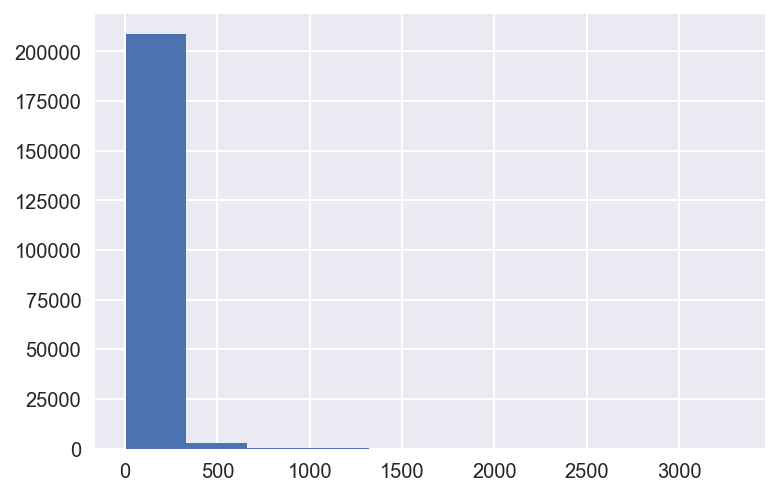

In [23]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords)
plt.show()

In [34]:
#CNN with LSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
# Little preprocessing required
sentences_train = train["Text"].fillna("_na_").values
sentences_test = test["Text"].fillna("_na_").values
list_classes = ['sentiment']
y = train[list_classes].values
y_test = test[list_classes].values
# Embedding parameter set
embed_size = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 3000 # max number of words in a comment to use
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences_train))
tokens_train = tokenizer.texts_to_sequences(sentences_train)
tokens_test = tokenizer.texts_to_sequences(sentences_test)
X_train = pad_sequences(tokens_train, maxlen=maxlen)
X_test = pad_sequences(tokens_test, maxlen=maxlen)

from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional

#CNN with LSTM
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(x)
x = Conv1D(16,4,activation='relu')(x)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=optimizers.rmsprop(lr = 0.001,decay = 1e-06), metrics=['accuracy'])
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#model.summary()
history=model.fit(X_train, y, batch_size=32, epochs=3,callbacks=callbacks_list, verbose=1, validation_split=0.2)
from keras.models import load_model
saved_model = load_model('weights-improvement.hdf5')


Train on 169541 samples, validate on 42386 samples
Epoch 1/128
169541/169541 [==============================] - 29725s 175ms/step - loss: 0.3267 - acc: 0.8670 - val_loss: 0.3283 - val_acc: 0.8650

Epoch 00001: val_acc improved from -inf to 0.86496, saving model to weights-improvement.hdf5
Epoch 2/128
169541/169541 [==============================] - 31025s 183ms/step - loss: 0.2461 - acc: 0.9046 - val_loss: 0.2483 - val_acc: 0.9075

Epoch 00002: val_acc improved from 0.86496 to 0.90754, saving model to weights-improvement.hdf5
Epoch 3/128
169541/169541 [==============================] - 32041s 189ms/step - loss: 0.2163 - acc: 0.9179 - val_loss: 0.2353 - val_acc: 0.9119

Epoch 00003: val_acc improved from 0.90754 to 0.91188, saving model to weights-improvement.hdf5
Epoch 4/128
169541/169541 [==============================] - 32105s 189ms/step - loss: 0.1983 - acc: 0.9265 - val_loss: 0.2302 - val_acc: 0.9153

Epoch 00004: val_acc improved from 0.91188 to 0.91533, saving model to weights-i

KeyboardInterrupt: 

In [ ]:
        y_pred = saved_model.predict(X_test)
        y_pred=y_pred.round()
        y_tests = test.sentiment

        # F1 score
        f1_score = metrics.f1_score(y_test, y_pred, average='macro')

        # macro accuracy (macro average)
        macc = metrics.f1_score(y_test, y_pred, pos_label=None, average='macro')

        # precision and recall
        recall = metrics.recall_score(y_test, y_pred, average='macro')
        precision = metrics.precision_score(y_test, y_pred, average='macro')

        results = [macc, f1_score, precision, recall]
        print("macc, f1_score, precision, recall", results)